# Content Segmentation

This notebook notebook evaluates the method of Satoshi Tsutsui, and David Crandall (2017)\[https://github.com/apple2373/figure-separator] in a subset figures of our dataset. 

We make available [here](https://drive.google.com/file/d/1BVVN736dIm2Gb39g1A9yHNwAJT7PuKX6/view?usp=sharing) an adapted version of FigureSeparator method, along with the ground-truth of the content segmentation

# Instructions
1. Generate the Panels ground-truths with the notebook `Generate Painels from the Annontation.ipynb` available on this repository
2. Download the files from this [here](https://drive.google.com/file/d/1BVVN736dIm2Gb39g1A9yHNwAJT7PuKX6/view?usp=sharing)
3. Unzip the files
4. With a kernel python3.6, install the requirements from panel_extraction_src/requirements.txt
>`pip install -r panel_extraction_src/requirements.txt`
5. Run the cells bellow

----

# Download and unzip groundtruth and model

In [11]:
%%bash

# Dowload and unzip groundtruth and model
FILENAME='panel_extraction_src.zip'
FILEID='1BVVN736dIm2Gb39g1A9yHNwAJT7PuKX6'
wget --load-cookies /tmp/cookies.txt -nc \
    "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=$FILEID" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILEID" \
    -O $FILENAME && rm -rf /tmp/cookies.txt
unzip -nq $FILENAME


--2021-01-15 16:14:22--  https://docs.google.com/uc?export=download&confirm=vtxN&id=1BVVN736dIm2Gb39g1A9yHNwAJT7PuKX6
Resolving docs.google.com (docs.google.com)... 172.217.4.46, 2607:f8b0:4009:804::200e
Connecting to docs.google.com (docs.google.com)|172.217.4.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/d7l1teim3i8mp448jipj3n6i6ili75sk/l0reh2rqv3345ju5f7sbkr7c02jbirrk/1610745225000/03284941598352038832/12994267095526203672Z/1BVVN736dIm2Gb39g1A9yHNwAJT7PuKX6?e=download [following]
--2021-01-15 16:14:22--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/d7l1teim3i8mp448jipj3n6i6ili75sk/l0reh2rqv3345ju5f7sbkr7c02jbirrk/1610745225000/03284941598352038832/12994267095526203672Z/1BVVN736dIm2Gb39g1A9yHNwAJT7PuKX6?e=download
Resolving doc-14-94-docs.googleusercontent.com (doc-14-94-docs.googleusercontent.com)... 216.58.192.225, 2607:f8b0:4009:80f::2001
Connecting to doc-14-94

# Import Cell

In [12]:
import os, json, shutil
from panel_extraction_src.PanelExtraction import PanelExtraction
import numpy as np
import cv2
from glob import glob
from PIL import Image
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Remove warnings
import warnings
warnings.filterwarnings('ignore')
# Initialize instance of PanelExtraction
panel_extraction=PanelExtraction("panel_extraction_src/panel_extraction.pb")
# Clear output
from IPython.display import clear_output
clear_output()

# Setup an experiemental environment

In [2]:
with open('figure-panel-segmentation.json','r') as js:
     fig_panel_setup = json.load(js)

In [3]:
os.makedirs('segmentation-exp/figures',exist_ok=True)
os.makedirs('segmentation-exp/groundtruth',exist_ok=True)
figure_id = 0
for article in fig_panel_setup:
    for fig in fig_panel_setup[article]['figures']:
        fig_path = fig_panel_setup[article]['figures'][fig]['figure-path']
        gt_path =  fig_panel_setup[article]['figures'][fig]['groundtruth-path']
        
        figure_id +=1
        # Organize figure
        if os.path.isfile(fig_path):
            ext = fig_path[fig_path.rfind(".")+1:]
            dest_name = f"segmentation-exp/figures/{figure_id:05d}.{ext}"
            shutil.copy(fig_path, dest_name)
        else:
            raise FileNotFoundError(fig_path)
        # Organize groundtruth
        if os.path.isfile(gt_path):
            ext = fig_path[fig_path.rfind(".")+1:]
            dest_name = f"segmentation-exp/groundtruth/{figure_id:05d}.{ext}"
            shutil.copy(gt_path, dest_name)
        else:
            raise FileNotFoundError(gt_path)
        
        

In [4]:
def create_panels_mask(img,panels):
    """
    Create a maks image based on the panels location
    """
    if ".gif" in img:
        img = np.array(Image.open(img))
    else:
        img = cv2.imread(img)
    color = (255, 255, 255)
    img = np.zeros_like(img)
    for panel in panels:
        start_point = (panel['x'],panel['y'])
        end_point = (panel['x']+panel['w'], panel['y']+panel['h'])
        img = cv2.rectangle(img, start_point, end_point, color, -1) 
    return img

# Run Method for each selected figure

In [5]:
figs = glob("segmentation-exp/figures/*")
figs.sort()

In [6]:
# Creates a folder to save all mask images resulting from 
# the panel extraction
os.makedirs("segmentation-exp/generated_panels_mask", exist_ok=True)

In [7]:
# For each figure apply the FigureSeparator method
# and save the resulting mask
total_figs = len(figs)
for fig_index, fig in enumerate(figs,start=1):
    # extracts the panels
    panels = panel_extraction.extract(fig)
    # create a maks image based on the panels location
    mask = create_panels_mask(fig,panels)
    
    # Fix fig name
    fig = fig.replace("figures",'generated_panels_mask')
    fig  = fig.split(".")[0] +".png"
    
    cv2.imwrite(fig,mask)
        
    
    print(f"Extracting {fig_index} / {total_figs}",end='\r',flush=True)
    
print('\nDone')


Extracting 303 / 303
Done


# Method Evaluation

In [8]:
# Read all the ground-truth files and the gerated masks
gt = sorted(glob("segmentation-exp/groundtruth/*"))
panels_mask = sorted(glob("segmentation-exp/generated_panels_mask/*"))
if len(gt) != len(panels_mask):
    raise "The number of mask does not match with the number of gt"

In [9]:
score = []
total_figs = len(gt)
for index in range(len(gt)):
    # ground-truth
    gt_mask = cv2.imread(gt[index],cv2.IMREAD_GRAYSCALE)
    gt_mask[gt_mask>0] =1
    gt_mask = gt_mask.flatten()
    # predicted mask
    pred_mask = cv2.imread(panels_mask[index],cv2.IMREAD_GRAYSCALE)
    pred_mask[pred_mask>0] =1
    pred_mask = pred_mask.flatten()
    
    score.append(jaccard_score(y_true=pred_mask, y_pred=gt_mask))
    print(f"Calculating Score {index+1} / {total_figs}",end='\r',flush=True)
print('\nDone')

Calculating Score 303 / 303
Done



## Plot Result

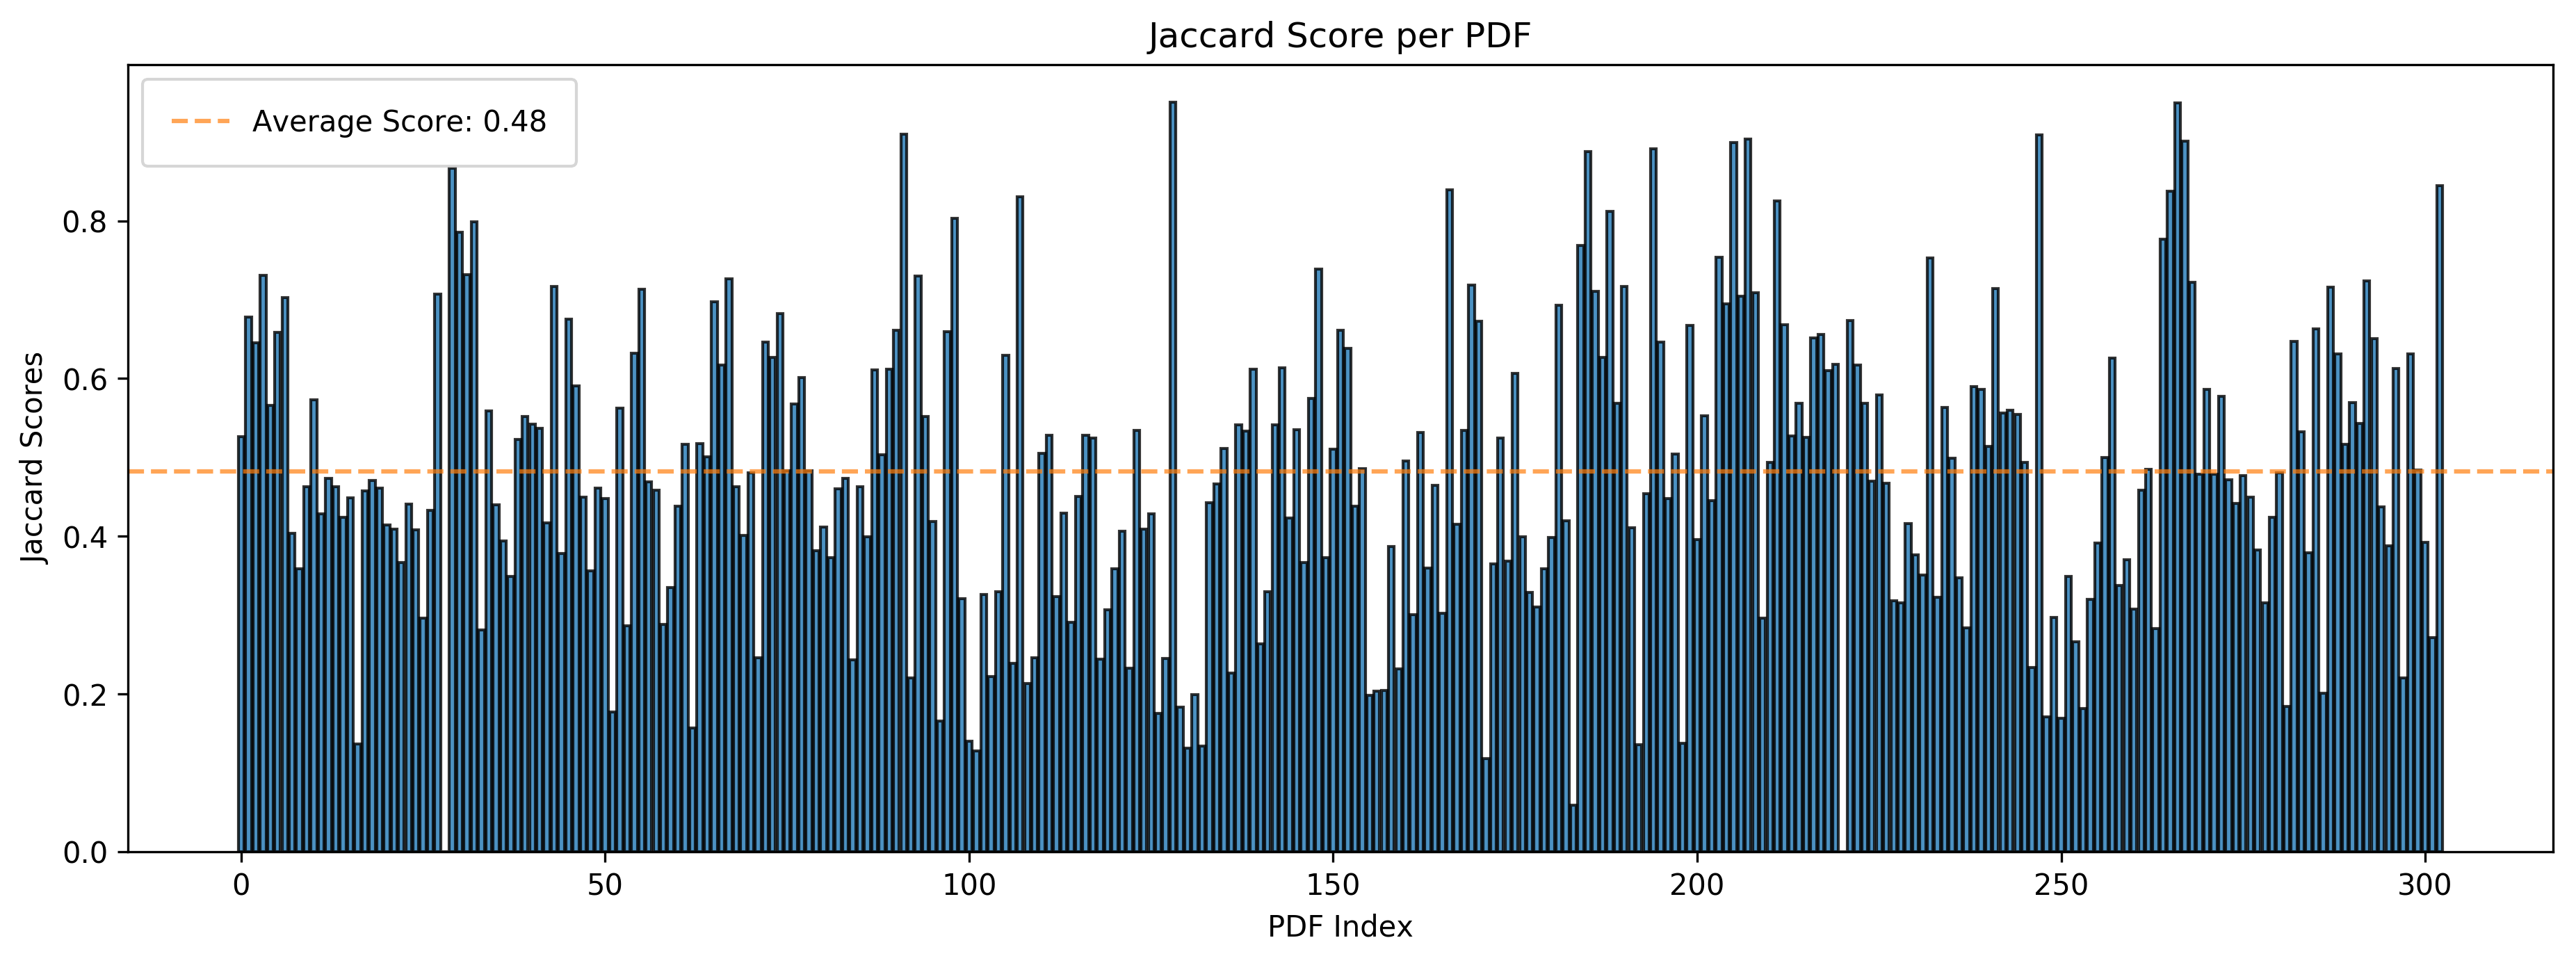

Score: 0.48 +/- 0.19


In [10]:
y = np.array(score)
x = np.arange(len(score))

plt.figure(figsize=(15,5), dpi=300)
plt.axhline(y.mean(), color=mcolors.TABLEAU_COLORS['tab:orange'], linestyle='dashed', linewidth=1.5,label=f'Average Score: {y.mean():.2f}', alpha=0.7)
plt.bar(x, score, color=mcolors.TABLEAU_COLORS['tab:blue'],edgecolor='black', alpha=0.8)
plt.title("Jaccard Score per PDF")
plt.xlabel('PDF Index')
plt.ylabel("Jaccard Scores")
plt.legend(fancybox=True, framealpha=0.8, borderpad=1)

plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")

----